### IMPORTING THE LIBRARIES




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

In [ ]:
from collections import Counter
import re

In [ ]:
import json

In [ ]:
df = pd.read_csv('/content/train.tsv' , sep= '\t')

### OVERVIEW OF DATASET

In [ ]:
df.head()

,Unnamed: 0,title,text,subject,date,label
0,2619,Ex-CIA head says Trump remarks on Russia inter...,Former CIA director John Brennan on Friday cri...,politicsNews,"July 22, 2017",1
1,16043,YOU WON’T BELIEVE HIS PUNISHMENT! HISPANIC STO...,How did this man come to OWN this store? There...,Government News,"Jun 19, 2017",0
2,876,Federal Reserve governor Powell's policy views...,President Donald Trump on Thursday tapped Fede...,politicsNews,"November 2, 2017",1
3,19963,SCOUNDREL HILLARY SUPPORTER STARTS “TrumpLeaks...,Hillary Clinton ally David Brock is offering t...,left-news,"Sep 17, 2016",0
4,10783,NANCY PELOSI ARROGANTLY DISMISSES Questions on...,Pleading ignorance is a perfect ploy for Nancy...,politics,"May 26, 2017",0


In [ ]:
df.columns

Index(['Unnamed: 0', 'title', 'text', 'subject', 'date', 'label'], dtype='object')

In [ ]:
df.describe(include = 'object')

,title,text,subject,date
count,30000,30000,30000,30000
unique,27149,27317,8,2381
top,Factbox: Trump fills top jobs for his administ...,Highlights for U.S. President Donald Trump’s a...,politicsNews,"December 6, 2017"
freq,9,6,7689,117


The dataset has total of 30000 rows with texual and temporal information about articles published.there is one column 'unnamed: 0' which must have been made onlt by shufflling the dataset while making the problem set.No null values but possibly duplicated rows in the dataset.

###EXPLORATORY DATA ANALYSIS & FEATURE ENGINEERING

firstly removing the unnamed column which is just because of shuffling of rows before proving dataset in the problem statement.

In [ ]:
df.drop('Unnamed: 0', axis = 1 , inplace = True)

Analysis of categorical features

In [ ]:
df.subject.value_counts().reset_index()

,subject,count
0,politicsNews,7689
1,worldnews,6833
2,News,6099
3,politics,4346
4,left-news,2953
5,Government News,1014
6,US_News,536
7,Middle-east,530


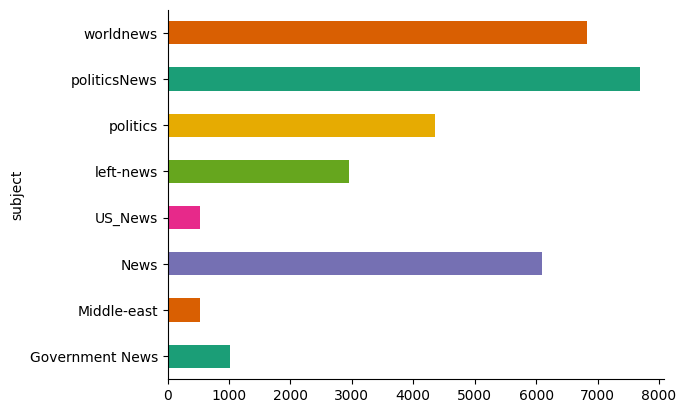

In [ ]:
df.groupby('subject').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
df.label.value_counts(normalize=True).reset_index()

,label,proportion
0,0,0.515933
1,1,0.484067


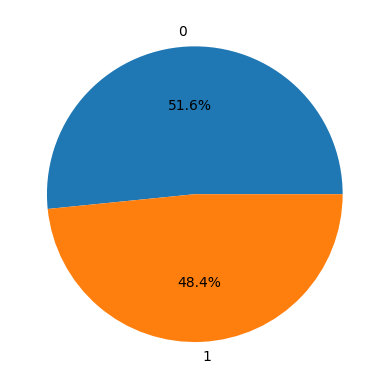

In [ ]:
plt.pie(df.label.value_counts(normalize=True), labels=df.label.value_counts(normalize=True).index, autopct='%1.1f%%')
plt.show()

In [ ]:
df.groupby(['subject','label']).size()

,,0
subject,label,
Government News,0,1014
Middle-east,0,530
News,0,6099
US_News,0,536
left-news,0,2953
politics,0,4346
politicsNews,1,7689
worldnews,1,6833


<Axes: ylabel='subject'>

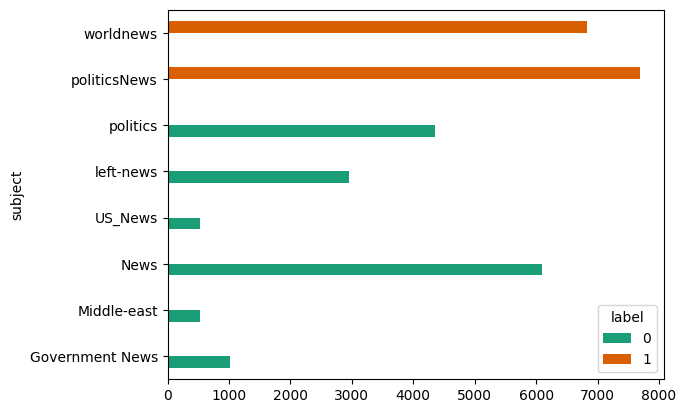

In [ ]:
df.groupby(['subject','label']).size().unstack().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))



*   the subject column repesents the type of article. it has two types of subjects which probably have same kinds of articles i.e. 'politicsNews' & 'politics'.
*   the categories of articles are imbalanced and some of them are overlapping with each other.(eg: world news probably also contain news of middle_east and USA. Also the category 'News' doesn't defines what exactly is the type of news the article contains)

*   the label column is pretty balanced where label '1' depicts that information of article is real while label '0' depicts misinformation.

*   the dataset suggests that the only type of articles with real or correct information are either of type "worldnews" and "politicnews"



temporal analysis

there is only one temporal feature in dataset: 'date' which is given as 'object' type so performing feature engineering only on date column while performing temporal analysis

In [ ]:
df.date.value_counts()

,count
date,
"December 6, 2017",117
"December 20, 2017",107
"September 21, 2017",106
"October 16, 2017",106
"November 9, 2017",104
...,...
"May 29, 2017",1
"Jun 11, 2017",1
"Aug 22, 2015",1


In [ ]:
#doing string manipulation to extract month names given
df.date.str.split(' ').str[0].value_counts()

,count
date,
November,2965
October,2859
September,2781
December,2394
May,2009
March,1661
January,1550
February,1511
June,1272




*   the date column has numerous anamolies
*   different names of same month are used which makes it inconsistent
*   some rows have URLs of images which will be dropped to avoid inconsistency




In [ ]:
#manually dealing with all inconsistency
df.loc[df['date'] == '14-Feb-18', 'date'] = 'February 14, 2018'
df.loc[df['date'] == '15-Feb-18', 'date'] = 'February 15, 2018'
df.loc[df['date'] == '16-Feb-18', 'date'] = 'February 16, 2018'
df.loc[df['date'] == '17-Feb-18', 'date'] = 'February 17, 2018'
df.loc[df['date'] == '18-Feb-18', 'date'] = 'February 18, 2018'
df.loc[df['date'] == '19-Feb-18', 'date'] = 'February 19, 2018'

In [ ]:
df.date.str.split(' ').str[0].value_counts()

,count
date,
November,2965
October,2859
September,2781
December,2394
May,2009
March,1661
January,1550
February,1534
June,1272


removing some rows which have some random texts or url in the date column


In [ ]:
df[df.date.str.split(' ').str[5] =='Worker']

,title,text,subject,date,label
22604,Homepage,[vc_row][vc_column width= 1/1 ][td_block_trend...,left-news,MSNBC HOST Rudely Assumes Steel Worker Would N...,0


In [ ]:
df.drop(index=22604, inplace=True)

In [ ]:
df[df['date'].str.contains('http')]

,title,text,subject,date,label
1208,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0
4104,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0
11119,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,left-news,https://fedup.wpengine.com/wp-content/uploads/...,0
11734,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,politics,https://fedup.wpengine.com/wp-content/uploads/...,0
18687,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,politics,https://100percentfedup.com/served-roy-moore-v...,0
23791,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,politics,https://100percentfedup.com/video-hillary-aske...,0
27806,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,Government News,https://fedup.wpengine.com/wp-content/uploads/...,0


In [ ]:
df = df[~df['date'].str.contains('http', na=False)]

In [ ]:
df.date.str.split(' ').str[0].value_counts()

,count
date,
November,2965
October,2859
September,2781
December,2394
May,2009
March,1661
January,1550
February,1534
June,1272


In [ ]:
df['month'] = df.date.str.split(' ').str[0]

In [ ]:
df.loc[df['month'] == 'Jan', 'month'] = 'January'
df.loc[df['month'] == 'Feb', 'month'] = 'February'
df.loc[df['month'] == 'Mar', 'month'] = 'March'
df.loc[df['month'] == 'Apr', 'month'] = 'April'
df.loc[df['month'] == 'Jun', 'month'] = 'June'
df.loc[df['month'] == 'Jul', 'month'] = 'July'
df.loc[df['month'] == 'Aug', 'month'] = 'August'
df.loc[df['month'] == 'Sep', 'month'] = 'September'
df.loc[df['month'] == 'Oct', 'month'] = 'October'
df.loc[df['month'] == 'Nov', 'month'] = 'November'
df.loc[df['month'] == 'Dec', 'month'] = 'December'

In [ ]:
df['date_number'] = df.date.str.split(' ').str[1].str.replace(',', '', regex=False)

In [ ]:
df['year'] = df.date.str.strip().str.split(' ').str[-1]

In [ ]:
df['date'] = df['month'] + ' ' + df['date_number'].astype(str) + ', ' + df['year'].astype(str)

df['date'] = pd.to_datetime(df['date'], format='%B %d, %Y')
df.drop(['month', 'date_number', 'year'], axis=1, inplace=True)

In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter


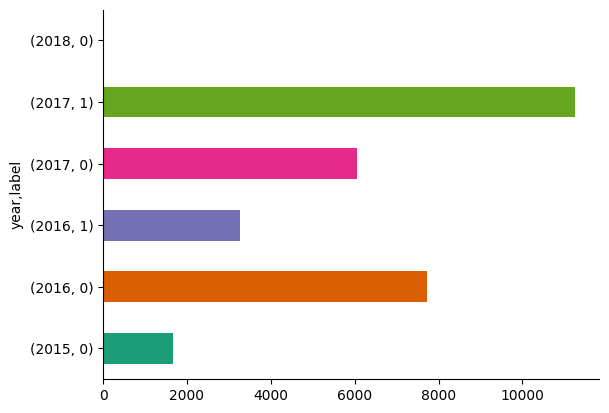

In [ ]:
df.groupby(['year','label']).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

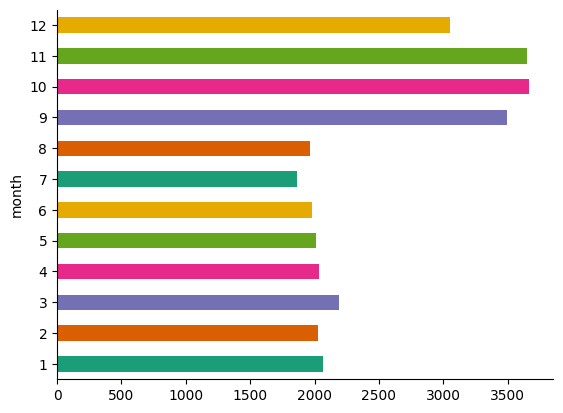

In [ ]:
df.groupby('month').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

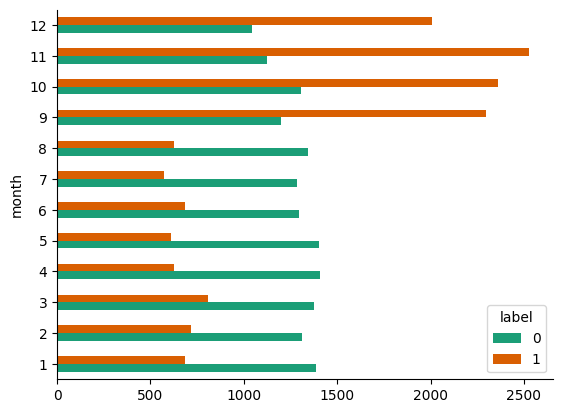

In [ ]:
df.groupby(['month','label']).size().unstack().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)



*   the date column had many wrong entries and inconsistencies which are now dealt with.
*   the year 2017 had highest number of articles with correct information while year 2016 had highest number of articles with misinformation.
*   the highest number of articles were publlished in the month of november and october.
*   the last quarter of the year had lowest numbers of misleading articles. an explaination for can be that the first three quarter are usually the months when political events mostly occur while the months of last quarter are usually the months of holidays.



Textual analysis with feature engineering

In [ ]:
df['article_word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['title_word_count'] = df['title'].apply(lambda x: len(str(x).split()))

<Axes: xlabel='article_word_count', ylabel='title_word_count'>

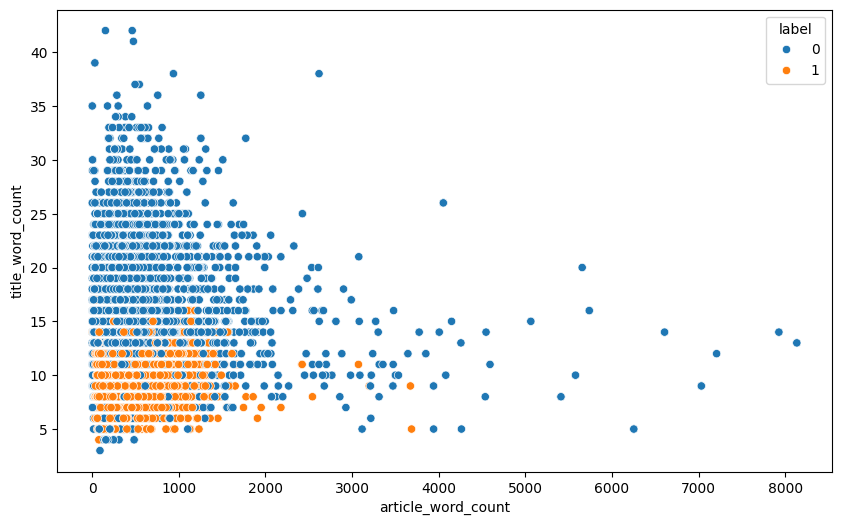

In [ ]:
figure = plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='article_word_count', y='title_word_count',hue='label')

In [ ]:
keywords = [
    "shocking", "outrageous", "unbelievable", "terrifying", "horrifying", "heartbreaking",
    "mind-blowing", "jaw-dropping", "scandalous", "explosive", "appalling",
    "breaking", "exclusive", "revealed", "leaked", "secret", "confidential",
    "hidden", "top-secret", "exposed", "uncovered",
    "guaranteed", "amazing", "incredible", "once-in-a-lifetime", "unstoppable",
    "life-changing", "miracle", "ultimate", "best-kept", "biggest-ever",
    "must-see", "don’t miss", "watch now", "act fast", "click here",
    "hurry", "limited time", "find out", "discover",
    "worst", "disaster", "dangerous", "deadly", "threatening",
    "collapse", "endangered", "warning", "red alert", "urgent",
    "truth", "lies", "hoax", "conspiracy", "agenda", "brainwashed",
    "fake", "fraudulent", "manipulated", "suppressed",
    "everyone", "no one", "millions", "billions", "always", "never",
    "forever", "all-time", "record-breaking", "unprecedented",
    "you won’t believe", "what happens next", "the truth about",
    "here’s why", "exposed", "viral", "trending", "game-changer",
    "epic fail", "devastating"
]

In [ ]:
def calculate_keyword_density(text, keywords):
    # Normalize text: lowercase and remove non-alphanumeric characters
    text = re.sub(r'\W+', ' ', text.lower())
    word_list = text.split()

    # Count total words and keyword occurrences
    total_words = len(word_list)
    keyword_count = sum(word_list.count(keyword) for keyword in keywords)

    # Calculate density
    return keyword_count / total_words if total_words > 0 else 0

# Apply the function to the 'text' column and create a new column
df['keyword_density'] = df['text'].apply(lambda x: calculate_keyword_density(x, keywords))

In [ ]:
df['title_keyword_density'] = df['title'].apply(lambda x: calculate_keyword_density(x, keywords))

(0.0, 0.05)

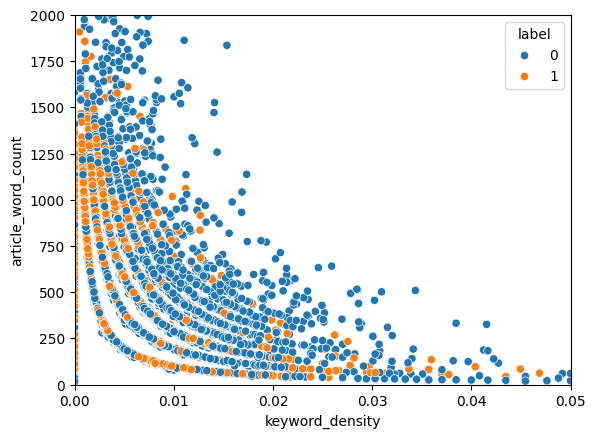

In [ ]:
sns.scatterplot(data=df, x='keyword_density', y='article_word_count',hue='label')
plt.ylim(0, 2000)
plt.xlim(0, 0.05)

<Axes: xlabel='title_keyword_density', ylabel='title_word_count'>

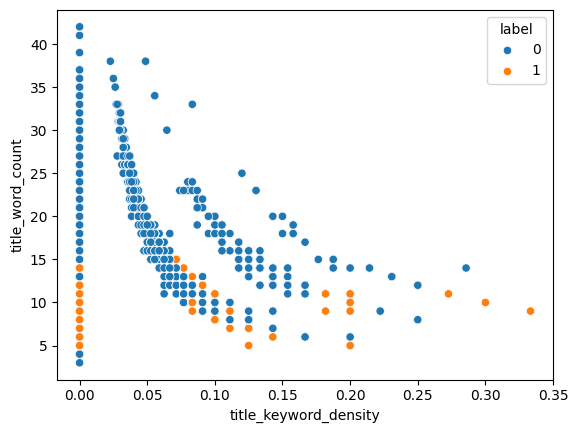

In [ ]:
sns.scatterplot(data=df, x='title_keyword_density', y='title_word_count',hue='label')


<Axes: xlabel='label', ylabel='title_keyword_density'>

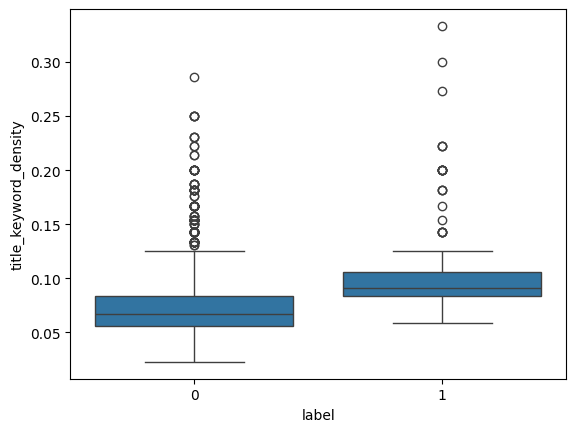

In [ ]:
non_zero_title_kd = df.loc[df['title_keyword_density']>0]

sns.boxplot(data=non_zero_title_kd, x='label', y='title_keyword_density')

In [ ]:
df.loc[df['keyword_density']>0].groupby(['label']).size()

,0
label,
0,10281
1,5838


In [ ]:
#df.to_csv('cleaned_data.csv', index=False)

### DATA CLEANING

Although i have already performed a lot of cleaning and feature engineering in temporal and texual features, still the dataset has some duplicates that add no value to model training and are needed to be removed from the data

In [ ]:
df.duplicated().sum()

92

In [ ]:
df.drop_duplicates(inplace=True)

from anlysis i have observed that there are outliers in some feartures like keyword_density and since the task is to classify between real and fake,outliers might contain useful insights to finding patterns to classify better,still will be performing normalizing and scaling techniques in the numerical features

In [ ]:
text = df['text']
numerical_features = df[['year', 'month', 'day',
       'day_of_week', 'week_of_year', 'quarter', 'article_word_count',
       'title_word_count', 'keyword_density', 'title_keyword_density']]
# Preprocessing the text to find sensational words and convert text into numerical format to feed in the algorithm
tfidf = TfidfVectorizer(max_features=5000)
text_features = tfidf.fit_transform(text).toarray()

# Normalize numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(numerical_features)

In [ ]:
pca = PCA(n_components=1500)
reduced_textual = pca.fit_transform(text_features)

# Check explained variance
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance Ratio for Textual Features: {explained_variance:.2f}")



Explained Variance Ratio for Textual Features: 0.74


In [ ]:
#Combine Reduced Textual and Raw Numerical Features
combined_features = np.hstack((reduced_textual, numerical_features))

### splitting and model training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combined_features, df['label'], test_size=0.2, random_state=42)

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rfc))

svc = SVC(kernel='linear', random_state=42)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)
print("\nSupport Vector Machine Classification Report:")
print(classification_report(y_test, y_pred_svc))

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("\nK-Nearest Neighbors Classification Report:")
print(classification_report(y_test, y_pred_knn))

xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3068
           1       0.98      0.95      0.96      2912

    accuracy                           0.97      5980
   macro avg       0.97      0.97      0.97      5980
weighted avg       0.97      0.97      0.97      5980


Support Vector Machine Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3068
           1       0.99      0.99      0.99      2912

    accuracy                           0.99      5980
   macro avg       0.99      0.99      0.99      5980
weighted avg       0.99      0.99      0.99      5980


K-Nearest Neighbors Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3068
           1       0.87      0.90      0.89      2912

    accuracy                           0.89      5980


In [ ]:
#scores_svc = cross_val_score(svc, X_train, y_train, cv=5)

#print(f"SVC Mean Accuracy: {scores_svc.mean()} ± {scores_svc.std()}")

'''output : SVC Mean Accuracy: 0.9896321070234114 ± 0.0010869565217391038'''

'''since other models were taking very long time and svc is showing tremendous performance on dataset even with cross validation, my final choice is svc'''


'since other models were taking very long time and svc is showing tremendous performance on dataset even with cross validation, my final choice is svc'

### classification for final test dataset

In [ ]:
test_df = pd.read_csv('/content/test (1).csv')

In [ ]:
#creating pipeline for all preprocessing steps before feeding dataset into model for predicting

test_df.drop('Unnamed: 0.1', axis = 1 , inplace = True)
test_df.loc[test_df['date'] == '15-Feb-18', 'date'] = 'February 15, 2018'
test_df.loc[test_df['date'] == '16-Feb-18', 'date'] = 'February 16, 2018'
test_df.loc[test_df['date'] == '17-Feb-18', 'date'] = 'February 17, 2018'
test_df.loc[test_df['date'] == '18-Feb-18', 'date'] = 'February 18, 2018'
test_df[test_df['date'].str.contains('http')]
test_df = test_df[~test_df['date'].str.contains('http', na=False)]
test_df['month'] = test_df.date.str.split(' ').str[0]
test_df.loc[test_df['month'] == 'Jan', 'month'] = 'January'
test_df.loc[test_df['month'] == 'Feb', 'month'] = 'February'
test_df.loc[test_df['month'] == 'Mar', 'month'] = 'March'
test_df.loc[test_df['month'] == 'Apr', 'month'] = 'April'
test_df.loc[test_df['month'] == 'Jun', 'month'] = 'June'
test_df.loc[test_df['month'] == 'Jul', 'month'] = 'July'
test_df.loc[test_df['month'] == 'Aug', 'month'] = 'August'
test_df.loc[test_df['month'] == 'Sep', 'month'] = 'September'
test_df.loc[test_df['month'] == 'Oct', 'month'] = 'October'
test_df.loc[test_df['month'] == 'Nov', 'month'] = 'November'
test_df.loc[test_df['month'] == 'Dec', 'month'] = 'December'

test_df['date_number'] = test_df.date.str.split(' ').str[1].str.replace(',', '', regex=False)
test_df['year'] = test_df.date.str.strip().str.split(' ').str[-1]
test_df['date'] = test_df['month'] + ' ' + test_df['date_number'].astype(str) + ', ' + test_df['year'].astype(str)
test_df['date'] = pd.to_datetime(test_df['date'], format='%B %d, %Y')
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['day_of_week'] = test_df['date'].dt.dayofweek
test_df['week_of_year'] = test_df['date'].dt.isocalendar().week
test_df['quarter'] = test_df['date'].dt.quarter





<ipython-input-101-cc7ab018f605>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['month'] = test_df.date.str.split(' ').str[0]
<ipython-input-101-cc7ab018f605>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['date_number'] = test_df.date.str.split(' ').str[1].str.replace(',', '', regex=False)
<ipython-input-101-cc7ab018f605>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [ ]:
test_df

,Unnamed: 0,title,text,subject,date,label,month,date_number,year,day,day_of_week,week_of_year,quarter
0,8104,Conservatives Will HATE What Donald Trump Just...,Donald Trump isn t exactly a stranger to makin...,News,2016-02-14,0,2,14,2016,14,6,6,1
1,7467,Trump victory may create new tension between U...,Donald Trump’s U.S. election victory may creat...,politicsNews,2016-11-09,1,11,9,2016,9,2,45,4
2,9473,WATCH: Hundreds of ILLEGAL ALIENS Storm Senate...,A couple of quick questions come to mind when ...,politics,2017-11-09,0,11,9,2017,9,3,45,4
3,276,"Democratic Senator Franken to resign: CNN, cit...",U.S. Democratic Senator Al Franken will announ...,politicsNews,2017-12-07,1,12,7,2017,7,3,49,4
4,19274,GANG OF DOMESTIC TERRORISTS Violently Attack L...,***WARNING*** Violence is graphic***This Trump...,left-news,2017-01-21,0,1,21,2017,21,5,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8262,5469,Russian MP says Flynn was forced to resign to ...,A senior Russian lawmaker said on Tuesday it w...,politicsNews,2017-02-14,1,2,14,2017,14,1,7,1
8263,5079,Highlights: The Trump presidency on March 7 at...,Highlights of the day for U.S. President Donal...,politicsNews,2017-03-07,1,3,7,2017,7,1,10,1
8264,20425,SHOCKER! WAS MUSLIM TERRORIST GAY? Used Gay Da...,"Of course, Mateen s Muslim father vehemently d...",left-news,2016-06-13,0,6,13,2016,13,0,24,2
8265,22063,John McCain and The Cancer of Conflict,Patrick Henningsen 21st Century WireThis week ...,US_News,2017-07-21,0,7,21,2017,21,4,29,3


In [ ]:
test_df['keyword_density'] = test_df['text'].apply(lambda x: calculate_keyword_density(x, keywords))
test_df['title_keyword_density'] = test_df['title'].apply(lambda x: calculate_keyword_density(x, keywords))

In [ ]:
test_df['article_word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))
test_df['title_word_count'] = test_df['title'].apply(lambda x: len(str(x).split()))
text = test_df['text']
numerical_features = test_df[['year', 'month', 'day',
       'day_of_week', 'week_of_year', 'quarter', 'article_word_count',
       'title_word_count', 'keyword_density', 'title_keyword_density']]
# Preprocessing the text to find sensational words and convert text into numerical format to feed in the algorithm
tfidf = TfidfVectorizer(max_features=5000)
text_features = tfidf.fit_transform(text).toarray()

# Normalize numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(numerical_features)

pca = PCA(n_components=1500)
reduced_textual = pca.fit_transform(text_features)

combined_features = np.hstack((reduced_textual, numerical_features))

code for saving predictions in desired format

In [ ]:
def predict_and_save(model, test_data, output_file):

    titles = test_df['title']
    features = combined_features


    predictions = svc.predict(features)


    result = [[title, int(prediction)] for title, prediction in zip(titles, predictions)]
    result_dict = {"results": result}


    with open(output_file, 'w') as f:
        json.dump(result_dict, f, indent=4)


if __name__ == "__main__":




    output_file_path = "/content/result.txt"
    predict_and_save(svc, test_df, output_file_path)
    print(f"Predictions saved to {output_file_path}")


Predictions saved to /content/result.txt
